# Notebook #3: the analysis and calculations

This notebook reproduces the calculations from the main paper, and the accompanying plots.

This notebook can be used without re-running any other notebooks. However, some numbers used here are calculated there, specifically regarding the local motion in '../ASTROMETRY'.

We note that the figures for the time scale analysis are combined into one plot using keynote. Those files are all included in this folder.

We take the following steps:

0) Import the necessary packages and plotting settings
1) Define the measurements, constants and some other basic input
2) Defining two useful functions
3) The equipartition analysis
4) The time scale analysis
5) The efficiencies versus electron density: acceleration and thermal efficiency
6) Plotting the radial profiles

### 0) Import the necessary packages and plotting settings

In [1]:
path = '/Library/Fonts/Arial Unicode.ttf'

import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import matplotlib.gridspec as gridspec

from scipy import interpolate
from scipy import optimize
from scipy.integrate import quad
import scipy.special

import os
from astropy import units as u
from astropy.units import cds
from matplotlib import colors
cds.enable()  

# If the font should not be changed, comment out the next two lines:
prop = font_manager.FontProperties(fname=path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['pdf.fonttype']=42

params = {'text.usetex':False, 'mathtext.fontset':'custom', 'mathtext.default':'regular'}
mpl.rcParams.update(params)

single_col = 8.9 # cm
double_col = 18.3 # cm
def cm2inch(value):
    return value/2.54
FS = 22
LS = 22
MS = 14
MEW= 1.5

%matplotlib inline

### 1) Define the measurements, constants and some other basic input

Constants and assumptions

In [2]:
m_e = 9.10938e-31 * u.kg # electron mass
m_p = 1.67262192e-27 * u.kg # proton mass

Z = 1.0 
a_ratio = 1. # Assumed ratio of protons to electrons 
eta = 1.0 + a_ratio

sigma_T = 6.6524e-25 * u.cm * u.cm # Thompson cross-section
sigma_SB = 5.67037442e-8 * u.Watt / (u.m**2.0) / (u.Kelvin**4.0) # Stefan-Boltzmann constant
    
c = 2.998e10 * u.cm / u.s # Speed of light
mu0 = cds.mu0 # Permeability of free space

planck = 6.6260701e-34 * u.Joule * u.s # Planck constant
red_planck = planck / (2*np.pi) # Reduced Planck constant
hred_c = (red_planck * c).to(u.Joule * u.m) # Reduced Planck constant times the speed of light in convenient units 

r0 = 2.8179403e-13 * u.cm # The classical electron radius
alpha = 0.0072973526 # The fine structure constant

# The axes in magnetic field and electron energy:
B_axis = 10**np.linspace(-1, 5, 100000, endpoint=True) * u.microGauss
E_elec = 10**np.linspace(6, 14, 1000, endpoint=True) * u.eV

Measurements / estimates for LS 2355

In [3]:
D = 2.2 * u.kpc

# Depth:
Delta = 35*u.arcsecond
Delta_phys = (Delta.to(u.radian).value)*D

# Total flux density over the full bow shock, and its geometry:
Snu_bowshock = 79.4 * u.milliJansky
dSnu_bowshock_stat = 0.3 * u.milliJansky
dSnu_bowshock_syst = 0.01*Snu_bowshock
dSnu_bowshock = (dSnu_bowshock_stat**2 + dSnu_bowshock_syst**2)**0.5

Abowshock = 3100 * u.arcsec**2
area_conv = ((1.0*u.arcsec).to(u.radian).value * D)**2
Abowshock_phys = 0.35 * u.parsec**2
Vbowshock_phys = 0.12 * u.parsec**3

# Beam volume:
beam_maj_phys = ((7.9*u.arcsecond).to(u.radian).value)*D
beam_min_phys = ((7.3*u.arcsecond).to(u.radian).value)*D
Abeam = np.pi * (beam_maj_phys * beam_min_phys)
Vbeam = (Abeam * Delta_phys).to(u.parsec**3)

# Observing frequency:
nu_obs = 944 * u.MHz

# Minimum and maximum particle energy:
E_min = 1e6 * u.eV
E_max = 1e13 * u.eV

# Measured size of R0:
R0 = 0.57*u.parsec
Rstar = 3*u.Rsun

# Stellar properties: 
L38 = 0.766557 #
vstar = 7.0 * u.km / u.s 
Tstar = 4.1e4 * u.Kelvin # Donor star temperature.

Mdot = 1.0e-6 * u.Msun / u.year # assumed as a standard value
vwind = 1000 * u.km / u.s # assumed as a standard value

a_dust = 0.2 * u.micrometer # Assumed dust grain radius. From Del Valle & Romero (2012)

Printing the errors with systematic errors included:

In [4]:
dSnu_bowshock

<Quantity 0.84878501 mJy>

The other regions:

In [5]:
# The HII-edge:
Snu_bowshock_HII = 53.8 * u.milliJansky
dSnu_bowshock_HII_stat = 0.3 * u.milliJansky
dSnu_bowshock_HII_syst = 0.01*Snu_bowshock_HII
dSnu_bowshock_HII = (dSnu_bowshock_HII_stat**2 + dSnu_bowshock_HII_syst**2)**0.5
dSnu_bowshock_HII

<Quantity 0.61599026 mJy>

In [6]:
# The bow shock in the 15 sigma contour:
Snu_bowshock_15s = 358.9 * u.milliJansky
dSnu_bowshock_15s_stat = 0.8 * u.milliJansky
dSnu_bowshock_15s_syst = 0.01*Snu_bowshock_15s
dSnu_bowshock_15s = (dSnu_bowshock_15s_stat**2 + dSnu_bowshock_15s_syst**2)**0.5
dSnu_bowshock_15s

<Quantity 3.6770805 mJy>

### 2) Defining two useful functions:

In [7]:
def gaunt(nu, T, z):
    # The Gaunt factor
        
    F1 = 128.*(cds.eps0**2)*(cds.k**3)*(T**3)
    F2 = m_e * (cds.e**4)*(nu**2)*(z**2)
    
    G = (3**0.5 / (2.*np.pi)) * (np.log(F1/F2) - 0.5772156649**2)
    
    return G

# Defining the function a(p)
def a_p(p):
    
    F1 = (np.pi**0.5)/(2.*(p+1.))
    F2 = scipy.special.gamma(p/4. + 19./12.)
    F3 = scipy.special.gamma(p/4. - 1./12.)
    F4 = scipy.special.gamma(p/4. + 5./4.)
    F5 = scipy.special.gamma(p/4. + 7./4.)
    
    return F1*F2*F3*F4/F5

### 3) The equipartition analysis:

In this analysis, we also define a number of functions regarding the maximum field strength and thermal ISM pressure, as these are relevant in the plot that is made for the equipartition analysis.

In [8]:
# Defining the axis for the energy integral:
E_integral_axis = 10**np.linspace(np.log10(E_min.value), np.log10(E_max.value), 1001, endpoint=True) * u.eV
dE_integral_axis = E_integral_axis[1:] - E_integral_axis[:-1]
E_integral_axis = E_integral_axis[:-1]

Defining the function that calculates the equipartition energy: see Van den Eijnden et al. (2022) for details:

In [9]:
def equipart(Snu_bowshock, D, p, nu_obs, Vbowshock_phys, B_axis, E_integral_axis, dE_integral_axis, printing=False):
    
    # Calculating the magnetic energy as a function of the magnetic field strength
    W_mag_vs_B = (Vbowshock_phys * (B_axis**2) / (2*cds.mu0)).to(u.erg)

    # Calculating the electron energy as a function of the magnetic field strength, in three steps due to the long equation:
    W_part_vs_B = 4*np.pi*(D**2)*Snu_bowshock*eta*4*np.pi*cds.eps0*c*m_e/((3.**0.5)*(cds.e**3.)*B_axis*a_p(p))
    W_part_vs_B = W_part_vs_B * ((3*cds.e*B_axis/(2*np.pi*nu_obs*(m_e**3)*(c**4)))**(-1.*(p-1.)/2.))
    W_part_vs_B = W_part_vs_B * sum(dE_integral_axis*(E_integral_axis**(1.-p)))
    
    # Finding the minimum (by finding the maximum of 1 over the total energy)
    B_equipartition = B_axis[np.argmax(1./(W_part_vs_B.to(u.erg)+W_mag_vs_B.to(u.erg)).value)]

    # Calculating Bstar:
    Bstar = (B_equipartition * (R0/Rstar) * 2.5).to(u.G)
    Bstar = Bstar.to(u.kG)
    
    min_E = min((W_part_vs_B.to(u.erg)+W_mag_vs_B.to(u.erg)).value)
    
    W_part_eq = 4*np.pi*(D**2)*Snu_bowshock*eta*4*np.pi*cds.eps0*c*m_e/((3.**0.5)*(cds.e**3.)*B_equipartition*a_p(p))
    W_part_eq = W_part_eq * ((3*cds.e*B_equipartition/(2*np.pi*nu_obs*(m_e**3)*(c**4)))**(-1.*(p-1.)/2.))
    W_part_eq = (W_part_eq * sum(dE_integral_axis*(E_integral_axis**(1.-p)))).to(u.erg)
   
    if printing:
        print('B_eq for p = '+str(p)+': '+ str(B_equipartition))
        print('Wpar:', W_part_eq.to(u.erg))
            
    return W_mag_vs_B, W_part_vs_B, B_equipartition, Bstar, min_E, W_part_eq.to(u.erg), W_part_eq.to(u.erg) 

Defining the function that calculates the maximum magnetic field for a given density and stellar velocity:

In [10]:
def compressibility(n_e=100.*u.cm**-3, vstar=7.0*u.km/u.s):
    
    Pthermal = 0.75 * m_p * n_e * (vstar**2)
    
    #print(Pthermal.to(u.newton/u.meter**2))
          
    Bmax = ((2*mu0*Pthermal)**0.5).to(u.microGauss)
    
    return Bmax

In [11]:
# Showing the maximum field for a standard input:
compressibility()

<Quantity 39.30497222 uG>

Defining three functions: 

- the mass loss rate for a given velocity, ISM density, $R_0$, and stellar velocity *without* thermal pressure correction
- the mass loss rate for a given velocity, ISM density, $R_0$, and stellar velocity *with* thermal pressure correction at a given ISM temperature
- the combination of mass loss rate times wind velocity, for a given ISM density, $R_0$, and stellar velocity *with* thermal pressure correction at a given ISM temperature

In [12]:
def Mdot_vs_v(vwind, n_e=100.*u.cm**-3, vstar=7.0*u.km/u.s, R0=0.57*u.parsec):
    
    return (4*np.pi*m_p*(vstar**2)*(R0**2)*n_e / vwind).to(u.solMass/u.yr)

def Mdot_vs_v_Tcorr(vwind, n_e=100.*u.cm**-3, vstar=7.0*u.km/u.s, R0=0.57*u.parsec, Te=1e4*u.Kelvin):
    
    return (4*np.pi*n_e*(R0**2)*(m_p*(vstar**2) + cds.k*Te) / vwind).to(u.solMass/u.yr)

def MdotV_Tcorr(n_e=100.*u.cm**-3, vstar=7.0*u.km/u.s, R0=0.57*u.parsec, Te=1e4*u.Kelvin):
    
    return (4*np.pi*n_e*(R0**2)*(m_p*(vstar**2) + cds.k*Te)).to(u.solMass*u.km/(u.yr*u.second))

Showing some example 'standard values' for these function with an without the thermal ISM pressure correction:

In [13]:
Mdot_vs_v(vwind=1000*u.km/u.second, n_e=1000.*u.cm**-3, vstar=vstar, R0=0.57*u.parsec)

<Quantity 5.05652998e-06 solMass / yr>

In [14]:
Mdot_vs_v_Tcorr(vwind=1000*u.km/u.second, n_e=500.*u.cm**-3, vstar=vstar, R0=0.57*u.parsec, Te=1e3*u.Kelvin)

<Quantity 2.95416928e-06 solMass / yr>

In [15]:
Mdot_vs_v_Tcorr(vwind=1000*u.km/u.second, n_e=1000.*u.cm**-3, vstar=vstar, R0=0.57*u.parsec, Te=1e3*u.Kelvin)

<Quantity 5.90833855e-06 solMass / yr>

In [16]:
MdotV_Tcorr(n_e=500.*u.cm**-3, vstar=vstar, R0=0.57*u.parsec, Te=1e4*u.Kelvin)

<Quantity 0.00678731 km solMass / (s yr)>

In [17]:
Mdot_vs_v_Tcorr(vwind=1000*u.km/u.second, n_e=500.*u.cm**-3, vstar=vstar, R0=0.57*u.parsec, Te=1e4*u.Kelvin)

<Quantity 6.78730784e-06 solMass / yr>

Performing the equipartition calculation for three values of p; plotting energy versus magnetic field and indicating maximum field strength.

This recreates Figure 6.

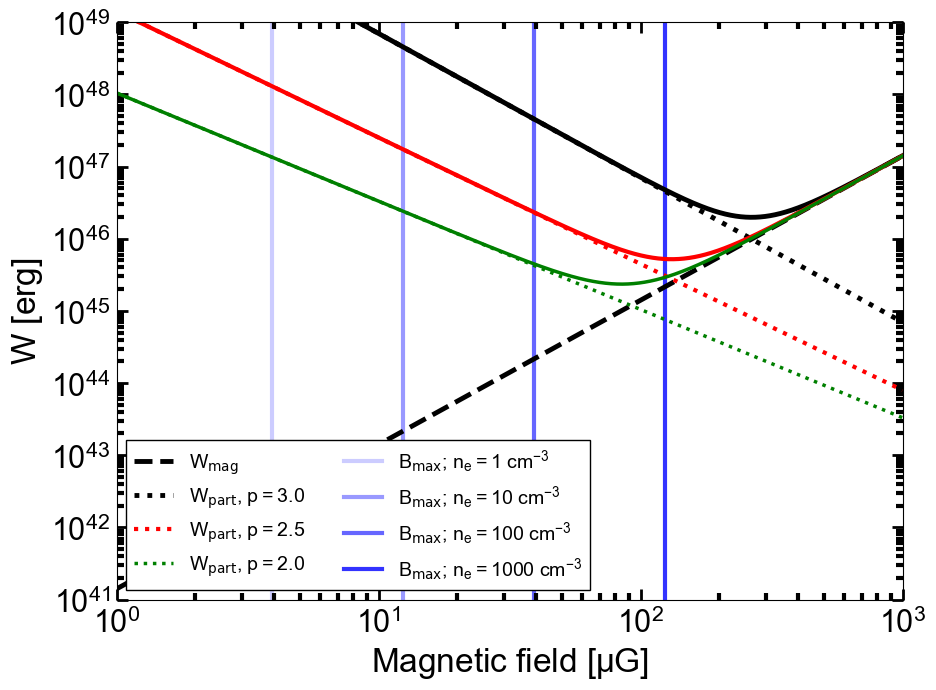

In [18]:
# Plotting the electron and magnetic energy, and their sum, versus magnetic field
fig = plt.figure(figsize=(cm2inch(2.7*single_col),cm2inch(2*single_col)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

# Plotting three cases: for three different values of p; and plotting the constituent values:
W_mag_vs_B, W_part_vs_B, B_equipartition, Bstar, min_E, W_part_eq, W_part_low = equipart(Snu_bowshock, D, 3.0, nu_obs, Vbowshock_phys, B_axis, E_integral_axis, dE_integral_axis)
ax.plot(B_axis, W_mag_vs_B.to(u.erg), 'k--', lw=3.5, label=r'$W_{\rm mag}$')
ax.plot(B_axis, W_part_vs_B.to(u.erg), 'k:', lw=3.5, label=r'$W_{\rm part}$, $p = 3.0$')
ax.plot(B_axis, W_part_vs_B.to(u.erg)+W_mag_vs_B.to(u.erg), 'k-', lw=3.5)

W_mag_vs_B, W_part_vs_B, B_equipartition, Bstar, min_E, W_part_eq, W_part_low = equipart(Snu_bowshock, D, 2.5, nu_obs, Vbowshock_phys, B_axis, E_integral_axis, dE_integral_axis)
ax.plot(B_axis, W_part_vs_B.to(u.erg), 'r:', lw=3, label=r'$W_{\rm part}$, $p = 2.5$')
ax.plot(B_axis, W_part_vs_B.to(u.erg)+W_mag_vs_B.to(u.erg), 'r-', lw=3)

W_mag_vs_B, W_part_vs_B, B_equipartition, Bstar, min_E, W_part_eq, W_part_low = equipart(Snu_bowshock, D, 2.0, nu_obs, Vbowshock_phys, B_axis, E_integral_axis, dE_integral_axis)
#ax.plot(B_axis, W_mag_vs_B.to(u.erg), 'g--', lw=2, label=r'$W_{\rm mag}$')
ax.plot(B_axis, W_part_vs_B.to(u.erg), 'g:', lw=2.5, label=r'$W_{\rm part}$, $p = 2.0$')
ax.plot(B_axis, W_part_vs_B.to(u.erg)+W_mag_vs_B.to(u.erg), 'g-', lw=2.5)

# The maximum field for different densities:
ax.plot([compressibility(n_e=1.*u.cm**-3).value]*2, [1, 1e100], 'b-', lw=3, alpha=0.2, zorder=-2, label=r'$B_{\rm max}$; $n_e = 1$ cm$^{-3}$')
ax.plot([compressibility(n_e=10.*u.cm**-3).value]*2, [1, 1e100], 'b-', lw=3, alpha=0.4, zorder=-2, label=r'$B_{\rm max}$; $n_e = 10$ cm$^{-3}$')
ax.plot([compressibility(n_e=100.*u.cm**-3).value]*2, [1, 1e100], 'b-', lw=3, alpha=0.6, zorder=-2, label=r'$B_{\rm max}$; $n_e = 100$ cm$^{-3}$')
ax.plot([compressibility(n_e=1000.*u.cm**-3).value]*2, [1, 1e100], 'b-', lw=3, alpha=0.8, zorder=-2, label=r'$B_{\rm max}$; $n_e = 1000$ cm$^{-3}$')

# Plotting ranges and labels:
ax.set_xlim(1e0, 1e3)
ax.set_ylim(1e41, 1e49)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Magnetic field [$\mu$G]', fontsize=FS+2)
ax.set_ylabel(r'$W$ [erg]', fontsize=FS+2)

# The legend:
legend = ax.legend(loc=3, fontsize=FS-8, ncol=2, frameon=True, framealpha=1.0, fancybox=False)
frame = legend.get_frame()
frame.set_edgecolor('black')

plt.tight_layout()
plt.savefig('equipart_v3.pdf')

### 4) The time scale analysis:

Here, we calculate all relevant energy gain and loss time scales. This follows the detailed explanation in the appendix of Van den Eijnden et al. (2022) and the accompanying paper reproduction package: https://github.com/jvandeneijnden/VelaX-1-MKAT. 

The main change here is the addition of diffusive escape, as described in the main paper.

We will consider two densities for this calculation; therefore, we calculate the mass loss rate and maximum magnetic field for both cases:

In [19]:
mdot_10 = Mdot_vs_v(vwind, n_e=10.*u.cm**-3, vstar=vstar, R0=0.57*u.parsec)
mdot_100 = Mdot_vs_v(vwind, n_e=100.*u.cm**-3, vstar=vstar, R0=0.57*u.parsec)

In [20]:
B_10 = compressibility(n_e=10.*u.cm**-3, vstar=vstar)
B_100 = compressibility(n_e=100.*u.cm**-3, vstar=vstar)

In [21]:
B_10, B_100

(<Quantity 12.42932356 uG>, <Quantity 39.30497222 uG>)

Calculating the WISE flux for the later IC calculation, as well as the dust temperature:

In [22]:
F_IR = 16.21 * u.Jansky # WISE band W4 region-integrated DN minus background, converted to Jansky
nu_IR = (12.1/22.)*2.481e13 * u.Hz # WISE band W4 effective frequency
L_IR = (4.0*np.pi*F_IR*nu_IR*(D**2)).to(u.erg/u.second)

Tdust = (27.0 * u.Kelvin) * ((a_dust / u.micrometer)**(-1./6.)) * (L38**(1./6.)) * ((R0 / u.parsec)**(-1./3.)) 
print('T_dust =', Tdust)

T_dust = 40.73720438493708 K


Synchrotron time scales for the two densities (and therefore magnetic fields):

In [23]:
Umag_10 = ((B_10**2)/(2*mu0))

t_sync_inverse_10 = (4./3.)*((sigma_T*c*Umag_10)/(m_e*c*c))*(E_elec / (m_e*c*c))
t_sync_10 = (1./t_sync_inverse_10).to(u.s)

Umag_100 = ((B_100**2)/(2*mu0))

t_sync_inverse_100 = (4./3.)*((sigma_T*c*Umag_100)/(m_e*c*c))*(E_elec / (m_e*c*c))
t_sync_100 = (1./t_sync_inverse_100).to(u.s)

Inverse Compton: Dust

In [24]:
# Calculate the Grey body correction from Khangulyan et al. 2014 (see also Del Palacio et al. 2018) for the dust
dust_surface = Abowshock_phys
kappa_dust = L_IR / ((dust_surface * sigma_SB * (Tdust**4.0)).to(u.erg / u.s))
print('kappa_dust =', kappa_dust)

kappa_dust = 0.002461404698987644


In [25]:
# Scaling E and T:
E_elec_scaled = E_elec / ((m_e*c*c).to(u.eV))
Tdust_scaled = ((cds.k * Tdust).to(u.eV)) / ((m_e*c*c).to(u.eV))

# The Thompson regime:
t_IC_inverse_Thompson = (4.0*c*E_elec_scaled / 9.0)*(np.pi*np.pi*kappa_dust*(Tdust_scaled**4.0)*(m_e**3.0)*(c**3.0))*(8*np.pi*r0*r0) / (15*(red_planck**3.0))
t_IC_dust_Thompson = (1. / t_IC_inverse_Thompson).to(u.s)

# The KN regime:
t_IC_dust_KNlimit = (5e-17 * u.s) * (Tdust_scaled**-2.3) * (E_elec_scaled**0.7) / kappa_dust

# The total cooling time scale:
t_IC_dust = t_IC_dust_Thompson + t_IC_dust_KNlimit

Inverse Compton: Star

In [26]:
kappa_star = (Rstar.to(u.parsec) / (2.*R0))**2.0
print('kappa_star =', kappa_star)

kappa_star = 3.5202679612170296e-15


In [27]:
Tstar_scaled = ((cds.k * Tstar).to(u.eV)) / ((m_e*c*c).to(u.eV))

t_IC_inverse_Thompson = (4.0*c*E_elec_scaled / 9.0)*(np.pi*np.pi*kappa_star*(Tstar_scaled**4.0)*(m_e**3.0)*(c**3.0))*(8*np.pi*r0*r0) / (15*(red_planck**3.0))
t_IC_star_Thompson = (1. / t_IC_inverse_Thompson).to(u.s)

t_IC_star_KNlimit = (5e-17 * u.s) * (Tstar_scaled**-2.3) * (E_elec_scaled**0.7) / kappa_star

t_IC_star = t_IC_star_Thompson + t_IC_star_KNlimit

Brehmsstraluhng: two calculations for the different stellar wind densities:

In [28]:
wind_density_10 = (mdot_10 / (4*np.pi*(R0**2.0)*vwind)).to(u.kg * u.m**-3.0)
wind_number_density_10 = (wind_density_10 / u.M_p).to(u.m**-3.0)

t_brehms_inverse_10 = 4*4*wind_number_density_10*(Z**2.0)*(r0**2.0)*alpha*c*np.log(2.0*E_elec / (u.M_e * c * c) - 1./3.)

t_brehms_10 = (1./t_brehms_inverse_10).to(u.s)

wind_density_100 = (mdot_100 / (4*np.pi*(R0**2.0)*vwind)).to(u.kg * u.m**-3.0)
wind_number_density_100 = (wind_density_100 / u.M_p).to(u.m**-3.0)

t_brehms_inverse_100 = 4*4*wind_number_density_10*(Z**2.0)*(r0**2.0)*alpha*c*np.log(2.0*E_elec / (u.M_e * c * c) - 1./3.)

t_brehms_100 = (1./t_brehms_inverse_100).to(u.s)

acceleration: two calculations for the different densities and therefore magnetic fields:

In [29]:
xi = 1.0
t_acc_10 = ((20./3.)*xi*E_elec / (cds.e * B_10 * (vwind**2.0))).to(u.s)

t_acc_100 = ((20./3.)*xi*E_elec / (cds.e * B_100 * (vwind**2.0))).to(u.s)

Escape: advection

In [30]:
t_adv = (Delta_phys / vwind).to(u.s)

Escape: diffusion: two scenarios, fast and slow

In [31]:
D10_slow = 1e25 * u.cm**2 / u.second
D10_fast = 1e27 * u.cm**2 / u.second # Note: this is unexpectedly fast!

diff_delta = 0.5

D_vs_E_slow = (D10_slow * ((E_elec / (10.*u.GeV))**diff_delta)).to(u.cm**2 / u.second)
D_vs_E_fast = (D10_fast * ((E_elec / (10.*u.GeV))**diff_delta)).to(u.cm**2 / u.second)

t_diff_slow = ((R0**2)/D_vs_E_slow).to(u.second)
t_diff_fast = ((R0**2)/D_vs_E_fast).to(u.second)

Plotting: note that these two plots are combined manually afterwards into one Figure.

Low density:

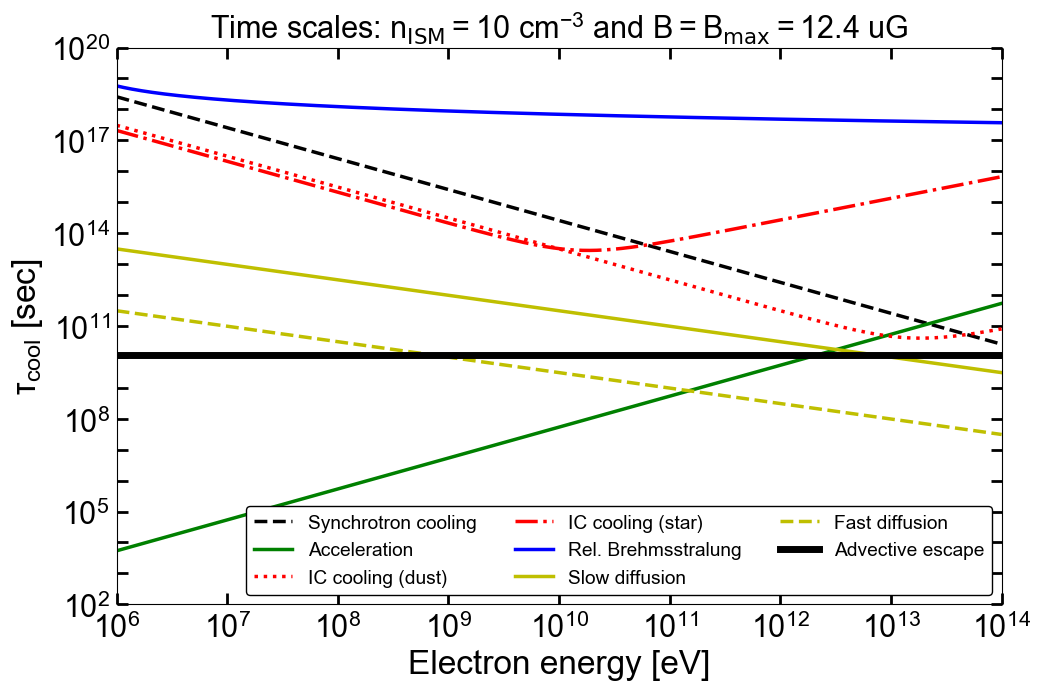

In [32]:
fig = plt.figure(figsize=(cm2inch(3*single_col),cm2inch(2*single_col)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.plot(E_elec, t_sync_10, 'k--', lw=2.5, label='Synchrotron cooling')
ax.plot(E_elec, t_acc_10, 'g-', lw=2.5, label='Acceleration')

ax.plot(E_elec, t_IC_dust, 'r:', lw=2.5, label='IC cooling (dust)')
ax.plot(E_elec, t_IC_star, 'r-.', lw=2.5, label='IC cooling (star)')
ax.plot(E_elec, t_brehms_10, 'b-', lw=2.5, label='Rel. Brehmsstralung')

ax.plot(E_elec, t_diff_slow, 'y-', lw=2.5, label='Slow diffusion')
ax.plot(E_elec, t_diff_fast, 'y--', lw=2.5, label='Fast diffusion')

ax.plot([1, 1e100], [t_adv.value, t_adv.value], 'k-', lw=5, label='Advective escape')

ax.set_xlim(1e6, 1e14)
ax.set_ylim(1e2, 1e20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks(np.logspace(6,14,9))
ax.set_yticks(np.logspace(2,20,19))
ax.set_yticklabels(['$10^2$','','','$10^5$','','','$10^8$','','','$10^{11}$','','','$10^{14}$','','','$10^{17}$','','','$10^{20}$'])

ax.set_xlabel('Electron energy [eV]', fontsize=FS+2)
ax.set_ylabel(r'$\tau_{cool}$ [sec]', fontsize=FS+2)

legend = ax.legend(loc=4, fontsize=FS-8.2, ncol=3, frameon=True, framealpha=1.0)
frame = legend.get_frame()
frame.set_edgecolor('black')

ax.set_title(r'Time scales: $n_{\rm ISM} = 10$ cm$^{-3}$ and $B = B_{\rm max} =$'+str(np.round(B_10,1)), fontsize=FS)

plt.tight_layout()
plt.savefig('tau_ne10_v3.pdf')

High density:

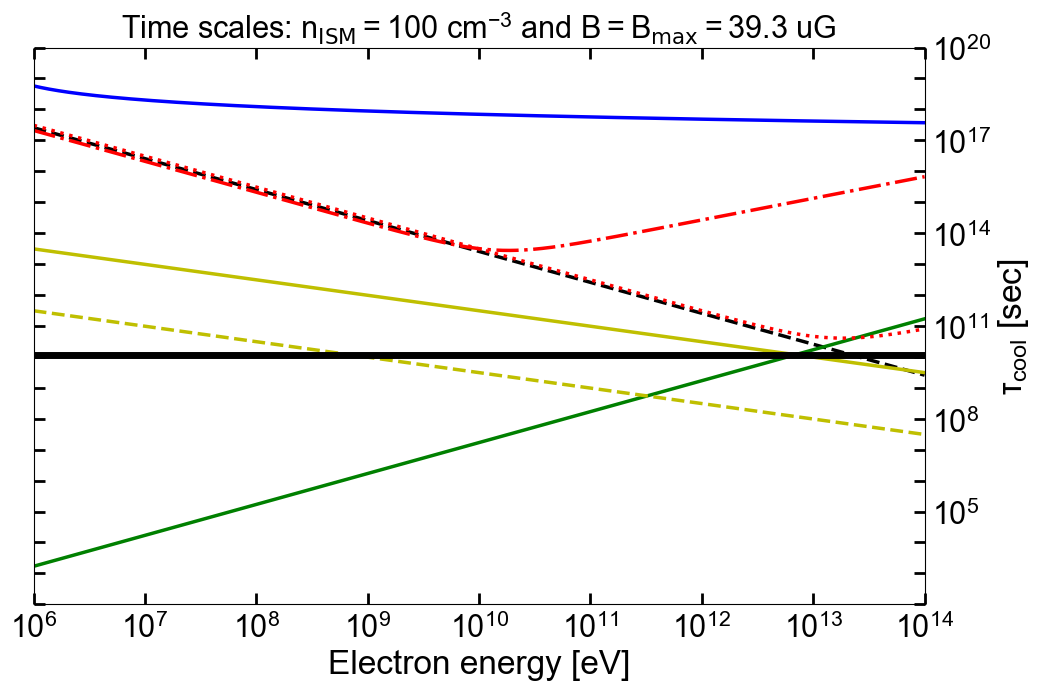

In [33]:
fig = plt.figure(figsize=(cm2inch(3*single_col),cm2inch(2*single_col)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.plot(E_elec, t_sync_100, 'k--', lw=2.5, label='Synchrotron cooling ($B = 0.25$ $\mu$G)')
ax.plot(E_elec, t_acc_100, 'g-', lw=2.5, label='Acceleration ($B = 0.25$ $\mu$G)')

ax.plot(E_elec, t_IC_dust, 'r:', lw=2.5, label='IC cooling (dust)')
ax.plot(E_elec, t_IC_star, 'r-.', lw=2.5, label='IC cooling (star)')
ax.plot(E_elec, t_brehms_100, 'b-', lw=2.5, label='Rel. Brehmsstralung')

ax.plot(E_elec, t_diff_slow, 'y-', lw=2.5, label='Slow diffusion')
ax.plot(E_elec, t_diff_fast, 'y--', lw=2.5, label='Fast diffusion')

ax.plot([1, 1e100], [t_adv.value, t_adv.value], 'k-', lw=5, label='Advective escape')

ax.set_xlim(1e6, 1e14)
ax.set_ylim(1e2, 1e20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks(np.logspace(6,14,9))
ax.set_yticks(np.logspace(2,20,19))
ax.set_yticklabels(['','','','$10^5$','','','$10^8$','','','$10^{11}$','','','$10^{14}$','','','$10^{17}$','','','$10^{20}$'])

ax.set_xlabel('Electron energy [eV]', fontsize=FS+2)
ax.set_ylabel(r'$\tau_{cool}$ [sec]', fontsize=FS+2)

ax.set_title(r'Time scales: $n_{\rm ISM} = 100$ cm$^{-3}$ and $B = B_{\rm max} =$'+str(np.round(B_100,1)), fontsize=FS)

plt.tight_layout()
plt.savefig('tau_ne100_v3.pdf')

### 5) The efficiencies versus electron density: acceleration and thermal efficiency

We follow the paper the define the acceleration and thermal emission efficiency and calculate this as a function of electron density. We consider three values of $p$, as discussed in the main paper.

In [34]:
# Defining the acceleration efficiency, where the mass loss rate times velocity is given by the MdotV_Tcorr function:
def Integral(p, Emin, Emax):
    if p == 2.:
        return np.log(Emax/Emin)
    else:
        return ((1./(2.-p)) * (Emax**(2.-p) - Emin**(2.-p))).to(u.J**(2.-p))

def eta_e_Tcorr(B, p, R0, D, Snu_tot, n_e, DR, Vbs, nu_obs, Emin, Emax, vstar, Te=1e4*u.K):
    
    MV = MdotV_Tcorr(n_e=n_e, vstar=vstar, R0=R0, Te=Te)
    
    F1 = 128.*(np.pi**3)*(R0**3.)*(D**2.)*Snu_tot*cds.eps0*c*m_e
    F2 = (3.**1.5)*MV*DR*Vbs*(cds.e**3)*B*a_p(p)
    
    F12 = (F1/F2).to(u.J**-1)
        
    F3 = 3.*cds.e*B / (2.*np.pi*nu_obs*(m_e**3)*(c**4))    
    F3 = F3**(-1.*(p-1.)/2.)
    F3 = F3.to(u.J**(p-1.)) 
        
    F4 = Integral(p, Emin, Emax)
    
    return (F12*F3*F4).to(u.dimensionless_unscaled)

The electron density axis and resulting magnetic field axis:

In [35]:
n_e_axis = np.logspace(0,4,1000) * u.cm**-3
Bmax_axis = compressibility(n_e=n_e_axis, vstar=vstar)

The thermal emission efficiency: the predicted thermal emission for two temperatures, given the electron density and bow shock geometry, divided buy the observed radio emission:

In [36]:
C_radio = 6.8e-38 * u.erg * u.cm**-3 * u.s**-1 * u.Hz**-1

T_plot = 1e4 * u.Kelvin
kappa_nu = C_radio * (T_plot.value**-0.5) * 0.25 * (n_e_axis.value**2) * gaunt(nu_obs, T_plot, Z)
S_thermal = kappa_nu * Vbowshock_phys / (4.*np.pi*(D**2))

eta_thermal_1e4 = (S_thermal / Snu_bowshock).to(u.dimensionless_unscaled) # The efficiency for T = 1e4 K

T_plot = 1e3 * u.Kelvin
kappa_nu = C_radio * (T_plot.value**-0.5) * 0.25 * (n_e_axis.value**2) * gaunt(nu_obs, T_plot, Z)
S_thermal = kappa_nu * Vbowshock_phys / (4.*np.pi*(D**2))

eta_thermal_1e3 = (S_thermal / Snu_bowshock).to(u.dimensionless_unscaled) # The efficiency for T = 1e3 K

Creating the plot:

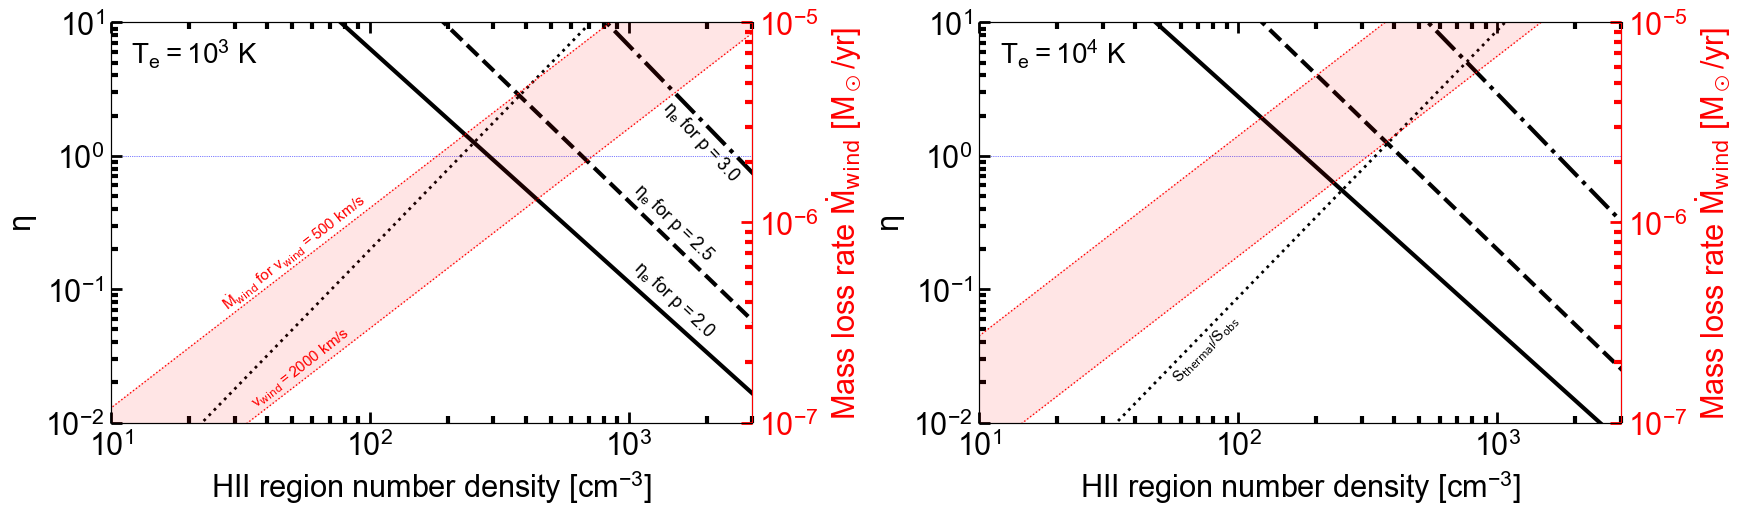

In [37]:
fig = plt.figure(figsize=(cm2inch(5*single_col),cm2inch(1.5*single_col)))

###### LEFT PANEL ######

ax = fig.add_subplot(121)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

# Plotting the thermal efficiency:
ax.plot(n_e_axis, eta_thermal_1e3, 'k:', lw=2.)

# Calculating the thermal efficiency for three values of p and plotting them:
eta_e_30 = eta_e_Tcorr(B=Bmax_axis, p=3.0, R0=R0, D=D, Snu_tot=Snu_bowshock, n_e=n_e_axis, DR=Delta_phys, 
                 Vbs=Vbowshock_phys, nu_obs=nu_obs, Emin=1e6*u.eV, Emax=1e13*u.eV, vstar=vstar, Te=1e3*u.Kelvin)
eta_e_25 = eta_e_Tcorr(B=Bmax_axis, p=2.5, R0=R0, D=D, Snu_tot=Snu_bowshock, n_e=n_e_axis, DR=Delta_phys, 
                 Vbs=Vbowshock_phys, nu_obs=nu_obs, Emin=1e6*u.eV, Emax=1e13*u.eV, vstar=vstar, Te=1e3*u.Kelvin)
eta_e_20 = eta_e_Tcorr(B=Bmax_axis, p=2.0, R0=R0, D=D, Snu_tot=Snu_bowshock, n_e=n_e_axis, DR=Delta_phys, 
                 Vbs=Vbowshock_phys, nu_obs=nu_obs, Emin=1e6*u.eV, Emax=1e13*u.eV, vstar=vstar, Te=1e3*u.Kelvin)
ax.plot(n_e_axis, eta_e_20, 'k-', lw=3)
ax.plot(n_e_axis, eta_e_30, 'k-.', lw=3)
ax.plot(n_e_axis, eta_e_25, 'k--', lw=3)

# Axis properties:
ax.set_ylabel(r'$\eta$', fontsize=FS)
ax.set_xlabel(r'HII region number density [cm$^{-3}$]', fontsize=FS)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(10,3e3)
ax.set_ylim(1e-2, 10)

# Copying the axis for the Mdot axis:
ax2 = ax.twinx()

ax2.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax2.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax2.yaxis.set_ticks_position('right')
ax2.xaxis.set_ticks_position('both')
ax2.get_yaxis().set_tick_params(direction='in', which='both')
ax2.get_xaxis().set_tick_params(direction='in', which='both')

# Labels:
ax2.set_ylabel(r'Mass loss rate $\dot{M}_{\rm wind}$ [$M_\odot$/yr]', fontsize=FS, color='r')
ax2.tick_params(axis='y', colors='red', which='both')
ax2.spines['right'].set_color('red')

# Calculating the correct mdot:
mdot_500 = Mdot_vs_v_Tcorr(vwind=500*u.km/u.second, n_e=n_e_axis, Te=1e3*u.Kelvin)
mdot_2000 = Mdot_vs_v_Tcorr(vwind=2000*u.km/u.second, n_e=n_e_axis, Te=1e3*u.Kelvin)

# Plotting the mdot:
ax2.plot(n_e_axis, mdot_500, 'r:', lw=1)
ax2.plot(n_e_axis, mdot_2000, 'r:', lw=1)
ax2.fill_between(n_e_axis.value, mdot_500.value, mdot_2000.value, color='r', alpha=0.1)

ax2.set_yscale('log')
ax2.set_xscale('log')

ax2.set_ylim(1e-7, 1e-5)

# Adding the text labels
ax.text(26, 0.07, r'$\dot{M}_{\rm wind}$ for $v_{\rm wind} = 500$ km/s', color='r', rotation=38, fontsize=FS-11)
ax.text(34, 0.013, r'$v_{\rm wind} = 2000$ km/s', color='r', rotation=38, fontsize=FS-11)

ax.text(1000, 0.165, r'$\eta_e$ for $p=2.5$', rotation=-44, fontsize=FS-9)
ax.text(1000, 0.044, r'$\eta_e$ for $p=2.0$', rotation=-43, fontsize=FS-9)
ax.text(1300, 0.65, r'$\eta_e$ for $p=3.0$', rotation=-47, fontsize=FS-9)

ax.plot([1, 1e10], [1,1], 'b:', lw=0.5, zorder=-2)

ax.text(12, 5, r'$T_e = 10^3$ K', fontsize=FS-2)

###### RIGHT PANEL: the same as the left panel ######

ax = fig.add_subplot(122)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.plot(n_e_axis, eta_thermal_1e4, 'k:', lw=2.)

eta_e_30 = eta_e_Tcorr(B=Bmax_axis, p=3.0, R0=R0, D=D, Snu_tot=Snu_bowshock, n_e=n_e_axis, DR=Delta_phys, 
                 Vbs=Vbowshock_phys, nu_obs=nu_obs, Emin=1e6*u.eV, Emax=1e13*u.eV, vstar=vstar, Te=1e4*u.Kelvin)
eta_e_25 = eta_e_Tcorr(B=Bmax_axis, p=2.5, R0=R0, D=D, Snu_tot=Snu_bowshock, n_e=n_e_axis, DR=Delta_phys, 
                 Vbs=Vbowshock_phys, nu_obs=nu_obs, Emin=1e6*u.eV, Emax=1e13*u.eV, vstar=vstar, Te=1e4*u.Kelvin)
eta_e_20 = eta_e_Tcorr(B=Bmax_axis, p=2.0, R0=R0, D=D, Snu_tot=Snu_bowshock, n_e=n_e_axis, DR=Delta_phys, 
                 Vbs=Vbowshock_phys, nu_obs=nu_obs, Emin=1e6*u.eV, Emax=1e13*u.eV, vstar=vstar, Te=1e4*u.Kelvin)
ax.plot(n_e_axis, eta_e_20, 'k-', lw=3)
ax.plot(n_e_axis, eta_e_30, 'k-.', lw=3)
ax.plot(n_e_axis, eta_e_25, 'k--', lw=3)

ax.set_ylabel(r'$\eta$', fontsize=FS)
ax.set_xlabel(r'HII region number density [cm$^{-3}$]', fontsize=FS)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(10,3e3)
ax.set_ylim(1e-2, 10)

ax2 = ax.twinx()

ax2.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax2.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax2.yaxis.set_ticks_position('right')
ax2.xaxis.set_ticks_position('both')
ax2.get_yaxis().set_tick_params(direction='in', which='both')
ax2.get_xaxis().set_tick_params(direction='in', which='both')

ax2.set_ylabel(r'Mass loss rate $\dot{M}_{\rm wind}$ [$M_\odot$/yr]', fontsize=FS, color='r')
ax2.tick_params(axis='y', colors='red', which='both')
ax2.spines['right'].set_color('red')

mdot_500 = Mdot_vs_v_Tcorr(vwind=500*u.km/u.second, n_e=n_e_axis, Te=1e4*u.Kelvin)
mdot_2000 = Mdot_vs_v_Tcorr(vwind=2000*u.km/u.second, n_e=n_e_axis, Te=1e4*u.Kelvin)

ax2.plot(n_e_axis, mdot_500, 'r:', lw=1)
ax2.plot(n_e_axis, mdot_2000, 'r:', lw=1)
ax2.fill_between(n_e_axis.value, mdot_500.value, mdot_2000.value, color='r', alpha=0.1)

ax2.set_yscale('log')
ax2.set_xscale('log')

ax2.set_ylim(1e-7, 1e-5)

# Adding the text labels
ax.text(54, 0.02, r'$S_{\rm thermal} / S_{\rm obs}$', rotation=45.7, fontsize=FS-11)

ax.plot([1, 1e10], [1,1], 'b:', lw=0.5, zorder=-2)
ax.text(12, 5, r'$T_e = 10^4$ K', fontsize=FS-2)

###### SAVING ######

plt.tight_layout()
plt.savefig('parspace_Tcorr_both_T.pdf')

### 6) Plotting the radial profiles:

These profiles are calculated using DS9 and plotted here. 

In [38]:
conv = 180 # arcsecond

In [39]:
x_scale_m10, F_m10 = np.genfromtxt('../IMAGE_PLOTTING/FITS_IMAGES/180arcsec_apex_m10.dat', unpack=True)
x_arcsec_m10 = conv * (x_scale_m10-1)/(max(x_scale_m10)-1)

x_scale_m20, F_m20 = np.genfromtxt('../IMAGE_PLOTTING/FITS_IMAGES/180arcsec_apex_m20.dat', unpack=True)
x_arcsec_m20 = conv * (x_scale_m20-1)/(max(x_scale_m20)-1)

In [40]:
# Function to find the peak location and its error from MC simulations using the flux uncertainty:
def find_peak(x_scale, F):
    scale = 180.
    sim = 1000
    
    R = (x_scale[np.argmax(F)] / len(x_scale)) * scale
    Rarray = []
    for i in range(sim):
        # Randomizing the profile
        Fsim = np.random.normal(loc=1000*F, scale=0.075)

        # Recalculating the peak radius
        Rarray.append((x_scale[np.argmax(Fsim)] / len(x_scale)) * scale)
    
    dR = np.std(Rarray)
    
    return R, dR

# Function to find the FWHM
def find_width(x_scale, F):
    sim = 1000
    scale = 180.
    
    FWHM = []
    for i in range(sim):

        # Randomizing the profile
        Fsim = np.random.normal(loc=1000*F, scale=0.075)

        # Definining the half max level
        halfmax = (max(Fsim) - np.mean(Fsim[60:]))/2.
        
        first = False
        second = False
        # Finding where the profile extends first above, and then first below, the half max value above the background level:
        for i in range(len(Fsim)):
            if Fsim[i] > (halfmax + np.mean(Fsim[60:])) and not first:
                left = (x_scale[i] / len(x_scale)) * scale
                first = True
                
        for i in range(np.argmax(Fsim),len(Fsim)):
            if Fsim[i] > (halfmax + np.mean(Fsim[60:])) and not second:
                right = (x_scale[i] / len(x_scale)) * scale
                second = True

        # Saving the difference in those radii as the FWHM:
        FWHM.append(right-left)    
        
    return np.mean(FWHM), np.std(FWHM)

Then, we use the functions above to calculate these values for all profiles

In [41]:
R_theta = []
dR_theta = []
for ANGLE in ['_m50','_m40','_m30','_m20','_m10','','_p10','_p20','_p30','_p40','_p50']:
    x_scale, F = np.genfromtxt('../IMAGE_PLOTTING/FITS_IMAGES/180arcsec_apex'+ANGLE+'.dat', unpack=True)
    R, dR = find_peak(x_scale, F)
        
    R_theta.append(R)
    dR_theta.append(dR)

In [42]:
FWHM_theta = []
dFWHM_theta = []
for ANGLE in ['_m50','_m40','_m30','_m20','_m10','','_p10','_p20','_p30','_p40','_p50']:
    x_scale, F = np.genfromtxt('../IMAGE_PLOTTING/FITS_IMAGES/180arcsec_apex'+ANGLE+'.dat', unpack=True)
    FWHM, dFWHM = find_width(x_scale, F)
        
    FWHM_theta.append(FWHM)
    dFWHM_theta.append(dFWHM)

For plotting, we use the array below but apply a 15 degree shift; the original apex direction (theta = 0) was defined using non-Gaia Oort constants. The 15 degree shift corrects this to Gaia-based Oort constants: the direction plotted in Figure 2 of the main paper.

In [43]:
theta = np.asarray([-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]) + 15.

In [44]:
R0_ang = 53.0 # Angular value of R0
theta_radian = (np.asarray(theta)*u.degree).to(u.radian)

# From Wilkin (1996): the theoretical shape of the shock:
R_theta_formula = abs(R0_ang * (1/np.sin(theta_radian))*np.sqrt(3.*(1.-theta_radian.value*np.cos(theta_radian)/np.sin(theta_radian))))
R_theta_formula

<Quantity [57.16897017, 55.07240721, 53.73344679, 53.08080859, 53.08080859,
           53.73344679, 55.07240721, 57.16897017, 60.14066307, 64.16658399,
           69.5131503 ]>

Plotting the profile and angular dependence $R(\theta)$ and $FWHM(\theta)$

/var/folders/lv/pjzz9j2j0l3c_7hb6_61m_yr0000gn/T/ipykernel_62358/2203651992.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


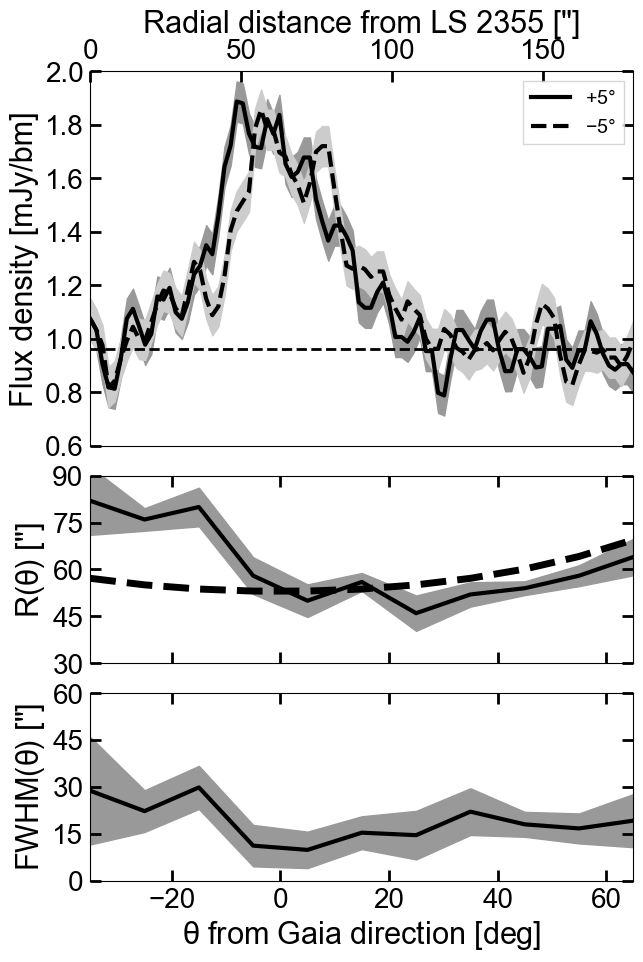

In [45]:
fig = plt.figure(figsize=(cm2inch(2*single_col),cm2inch(3.*single_col)))

gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1]) 
gs.update(wspace=0.025, hspace=0.12)

# MAIN / TOP PANEL:

ax = plt.subplot(gs[0])
ax.tick_params(labelsize=LS-2, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS-2, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

# Plotting the two profiles: note that m10 (== -10) becomes +5, given the offset. m20 (== -20) becomes -5 with the offset.
ax.plot(x_arcsec_m10, 1000*F_m10, 'k-', lw=3, label=r'$+5\degree$')
ax.fill_between(x_arcsec_m10, 1000*F_m10-0.075, 1000*F_m10+0.075, color='0.6')

ax.plot([0,200], [np.mean(1000*F_m10[60:])]*2, 'k--', lw=2)

ax.plot(x_arcsec_m20, 1000*F_m20, 'k--', lw=3, label=r'$-5\degree$')
ax.fill_between(x_arcsec_m10, 1000*F_m20-0.075, 1000*F_m20+0.075, color='0.8')

ax.set_xlabel('Radial distance from LS 2355 ["]', fontsize=FS)
ax.set_ylabel('Flux density [mJy/bm]', fontsize=FS)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

ax.set_xlim(0, 180)
ax.set_ylim(0.6, 2)

ax.set_yticks(np.linspace(0.6, 2, 8))

ax.legend(loc=1, fontsize=FS-8, fancybox=False)

# MIDDLE PANEL:

ax = plt.subplot(gs[1])

ax.tick_params(labelsize=LS-2, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS-2, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.plot(theta, R_theta, 'k-', lw=3)
ax.fill_between(theta, np.asarray(R_theta)-np.asarray(dR_theta), np.asarray(R_theta)+np.asarray(dR_theta), color='0.6')
ax.plot(theta, R_theta_formula, 'k--', lw=5)

ax.set_ylim(30, 90)
ax.set_xlim(-50+15, 50+15) # Note the same offset of 15 degrees.

ax.set_yticks(np.linspace(30, 90, 5))
ax.set_ylabel(r'R($\theta$) ["]', fontsize=FS)

ax.set_xticklabels([])

# BOTTOM PANEL:

ax = plt.subplot(gs[2])

ax.tick_params(labelsize=LS-2, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS-2, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.plot(theta, FWHM_theta, 'k-', lw=3)
ax.fill_between(theta, np.asarray(FWHM_theta)-np.asarray(dFWHM_theta), np.asarray(FWHM_theta)+np.asarray(dFWHM_theta), color='0.6')

ax.set_ylim(0, 60)
ax.set_xlim(-50+15, 50+15) # Note the same offset of 15 degrees.
ax.set_yticks(np.linspace(0, 60, 5))

ax.set_ylabel(r'FWHM($\theta$) ["]', fontsize=FS)
ax.set_xlabel(r'$\theta$ from Gaia direction [deg]', fontsize=FS)

plt.tight_layout()
plt.savefig('Allthree_radial_v3.pdf')